In [34]:
import ee
import wxee
import xarray as xr
import geopandas as gpd
from rasterio.plot import show

In [2]:
#ee.Authenticate()
wxee.Initialize()

In [18]:
def landsatMask(image):
    qa = image.select('QA_PIXEL')
    waterBitMask = (1 << 7)
    cloudShadowBitMask = (1 << 4)
    snowBitMask = (1 << 5)
    cirrusBitMask = (1 << 2)
    clearBitMask = (1 << 6)
    cloudBitMask = (1 << 3)
    dilcloudBitMask = (1 << 1)
    maskWater = qa.bitwiseAnd(waterBitMask).eq(0)
    maskShadow = qa.bitwiseAnd(cloudShadowBitMask).eq(0)
    maskSnow = qa.bitwiseAnd(snowBitMask).eq(0)
    maskCirrus = qa.bitwiseAnd(cirrusBitMask).eq(0)
    maskCloud = qa.bitwiseAnd(cloudBitMask).eq(0)
    maskDilCloud = qa.bitwiseAnd(dilcloudBitMask).eq(0)
    return image.updateMask(
        maskWater).updateMask(
        maskShadow).updateMask(
        maskSnow).updateMask(
        maskCirrus).updateMask(
        maskCloud).updateMask(
        maskDilCloud).copyProperties(image, ["system:time_start"])


# Applies scaling factors.
def applyScaleFactors(image):
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermalBands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
    return image.addBands(opticalBands, None, True).addBands(thermalBands, None, True)
    
# Define a function to add NDVI to Landsat 8 collection
def addNDVI_L7(image):
    ndvi = image.normalizedDifference(['SR_B4', 'SR_B3']).rename('NDVI')
    return image.addBands(ndvi)

# Define a function to add NDVI to Landsat 8 collection
def addNDVI_L8(image):
    ndvi = image.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')
    return image.addBands(ndvi)

def weeklyAvg(img):
    dstamp = ee.Date(img.get('system:time_start'))
    ddiff = dstamp.getRelative('week', 'year')
    img = img.select(['NDVI', 'QA_PIXEL']).set('date', dstamp)
    return img.addBands(ee.Image(ddiff).toFloat().rename('t')).set('t', ddiff)

def getWeek(img):
    dstamp = ee.Date(img.get('system:time_start'))
    ddiff = dstamp.getRelative('week', 'year')
    return ee.Number(ddiff)

k = ee.Kernel.fixed(41, 41,
                    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
                      0, 0, 0, 0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
                      0, 0, 0, 0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
                      0, 0, 0, 0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                      0, 0, 0, 0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
                      0, 0, 0, 0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
                      0, 0, 0, 0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
                      0, 0, 0, 0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                      0, 0, 0, 0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
                      0, 0, 0, 0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
                      0, 0, 0, 0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
                      0, 0, 0, 0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                      0, 0, 0, 0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
                      0, 0, 0, 0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
                      0, 0, 0, 0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
                      0, 0, 0, 0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                      0, 0, 0, 0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
                      0, 0, 0, 0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
                      0, 0, 0, 0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
                      0, 0, 0, 0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                      0, 0, 0, 0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
                      0, 0, 0, 0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                      0, 0, 0, 0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                      0, 0, 0, 0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                      0, 0, 0, 0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                      0, 0, 0, 0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                      0, 0, 0, 0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                      0, 0, 0, 0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                      0, 0, 0, 0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                      0, 0, 0, 0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                      0, 0, 0, 0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                      0, 0, 0, 0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                      0, 0, 0, 0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                      0, 0, 0, 0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                      0, 0, 0, 0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                      0, 0, 0, 0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                      0, 0, 0, 0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                      0, 0, 0, 0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                      0, 0, 0, 0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                      0, 0, 0, 0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                      0, 0, 0, 0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                      0, 0, 0, 0, 0, 0, 0, 0]])

def defringeLandsat(img):
    m = img.mask().reduce(ee.Reducer.min())
    sum = m.reduceNeighborhood(ee.Reducer.sum(), k, 'kernel').gte(279)
    return img.mask(sum)

In [19]:
collectionL5 = ee.ImageCollection(
    "LANDSAT/LT05/C02/T1_L2").filterDate(
    '1985-01-01', '2015-12-31').map(
    landsatMask).map(
    applyScaleFactors).map(
    addNDVI_L7).select(
    ['NDVI', 'QA_PIXEL']).map(
    lambda i: i.set('Landsat_sort', 3))

collectionL7 = ee.ImageCollection(
    "LANDSAT/LE07/C02/T1_L2").filterDate(
    '2013-03-01', '2015-12-31').map(
    landsatMask).map(
    applyScaleFactors).map(
    addNDVI_L7).map(
    defringeLandsat).select(
    ['NDVI', 'QA_PIXEL']).map(
    lambda i: i.set('Landsat_sort', 4))

collectionL8 = ee.ImageCollection(
    "LANDSAT/LC08/C02/T1_L2").map(
    landsatMask).map(
    applyScaleFactors).map(
    addNDVI_L8).select(
    ['NDVI', 'QA_PIXEL']).map(
    lambda i: i.set('Landsat_sort', 2))

collectionL9 = ee.ImageCollection(
    "LANDSAT/LC09/C02/T1_L2").map(
    landsatMask).map(
    applyScaleFactors).map(
    addNDVI_L8).select(
    ['NDVI', 'QA_PIXEL']).map(
    lambda i: i.set('Landsat_sort', 1))

In [227]:
cper_f ='../hls_nrt/data/ground/cper_pastures_2017_clip.shp'
cper = gpd.read_file(cper_f)
cper['dissolvefield'] = 1
cper.geometry = cper.buffer(50)
cper=cper.dissolve('dissolvefield')
cper = cper.to_crs(4326)

In [250]:
[min_x, min_y, max_x, max_y] = cper.to_crs(4326).total_bounds
polygon = ee.Geometry.Polygon([
    [[min_x, max_y], [max_x, max_y], [max_x, min_y], [min_x, min_y], [min_x, max_y]]
])

In [289]:
colAvgL8 = collectionL8.filterDate('2013-03-01', '2021-12-31').map(weeklyAvg)
colAvgL7 = collectionL7.map(weeklyAvg)
colAvgL5 = collectionL5.map(weeklyAvg)
colAvg = colAvgL8.merge(colAvgL7.merge(colAvgL5)).select('NDVI').filterBounds(polygon)#.map(lambda x: x.reproject(crs='EPSG:32613'))

In [322]:
weeks = ee.List.sequence(0, 52)
col_wkly = ee.ImageCollection.fromImages(
    weeks.map(lambda w: colAvg.filter(
        ee.Filter.gte('t', ee.Number(w).subtract(1))).filter(
        ee.Filter.lte('t', ee.Number(w).add(1))).mean().set(
            'system:time_start', ee.Date.fromYMD(2020, 1, 1).advance(w, 'week')))
)

In [325]:
#wk_sel= 42
#test = colAvg.select('NDVI').filterBounds(polygon).reduce(ee.Reducer.mean().group(0))#.filter(ee.Filter.eq('t', wk_sel))
test = col_wkly
#.map(lambda x: x.reproject(crs=landsat_proj)).first()

In [326]:
col_wkly_xr = col_wkly.wx.to_xarray(scale=30, max_attempts=50, region=polygon, crs='EPSG:32613')

Requesting data:   0%|          | 0/53 [00:00<?, ?it/s]

In [334]:
col_wkly_xr = col_wkly_xr.rename({'time': 'date'})

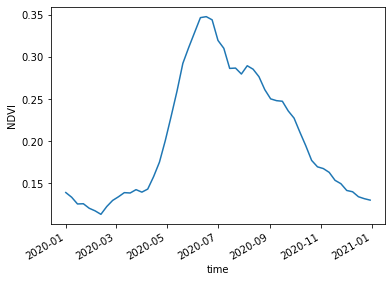

In [327]:
col_wkly_xr.mean(dim=['y', 'x'])['NDVI'].plot()

In [347]:
import os
import rioxarray
outDIR = '/mnt/c/Users/TBGPEA-Sean/git_repos/hls_nrt/data/ee_lta'
if not os.path.exists(outDIR):
    os.mkdir(outDIR)
col_wkly_xr.rio.reproject("EPSG:3857").to_netcdf(os.path.join(outDIR, 'cper_ee_ndvi_landsat_wkly_lta.nc'))

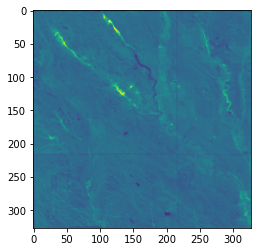

<AxesSubplot:>

In [332]:
show(test_xr['NDVI'].isel(time=35).data, vmin=0.05, vmax=0.6)

In [341]:
col_wkly_xr = col_wkly_xr.rename({'time': 'date'})